In [1]:
import pandas as pd
import numpy as np
from difflib import get_close_matches
from datetime import datetime
from os import listdir
from bs4 import BeautifulSoup
import quopri
import re

# Historical Standard Deviation

In [37]:
historical = pd.read_csv("./data/linestar_data.csv")
stds = historical.groupby("Name").std()["Scored"]

fill_std = stds.mean()

stds = stds.replace(np.nan, fill_std)
stds.name = "Scored_Std"

In [38]:
stds.to_csv("./data/stds.csv")

# Slate Data

In [2]:
name_pattern = re.compile(r"\([^()]*\)")
team_pattern = re.compile(r"[\$,]")

def linestar_proj():
    html = open("./data/proj.mhtml", "r")
    html = quopri.decodestring(html.read())
    soup = BeautifulSoup(html, features="html.parser")
    
    table = soup.find_all("table")[0]
    
    # Find column index numbers for columns we want
    # This is to avoid issues when columns change between before games and after games
    header_idx = {"Player": None, "Salary": None, "Consensus": None, "Order": None, "pOwn": None}
    # Ignore first columns that have filters etcetera
    for num, header in enumerate(table.find_all("th")[2:]):
        if header.text in header_idx.keys():
            # Position column always in front, so add 1 to index value
            header_idx[header.text] = num + 1
    
    data = []
    rows = table.find_all("tr", class_="playerCardRow")
    for row in rows:
        # Ignore first 4 columns that have checkboxes and other things
        cells = row.find_all("td")[4:]
        try:
            player_data = {"Position": cells[0].text,
                           "Player": name_pattern.sub("",
                                                      cells[header_idx["Player"]].find(class_="playername").text
                                                     ).rstrip(),
                           "Team": cells[header_idx["Player"]].find(class_="playerTeam").text[2:],
                           "Salary": int(team_pattern.sub("", cells[header_idx["Salary"]].text)),
                           "Consensus": float(cells[header_idx["Consensus"]].text),
                           "Order": int(cells[header_idx["Order"]].text.replace("-", "0")),
                           "pOwn": float(cells[header_idx["pOwn"]].text.replace("%", "")) / 100
                          }
        except:
            print(cells)
            raise ValueError
        data.append(player_data)
    return pd.DataFrame(data)

In [3]:
def opp_pitcher(x):
    # If player is pitcher, return nothing
    if x["Position"] == "P":
        return np.nan

    series = slate.loc[
        (slate["Team"] == x["Opponent"]) & (slate["Position"] == "P"), "Id"
    ]
    if len(series) == 0:
        return np.nan
    if len(series) > 1:
        raise ValueError("Multiple Opposing Pitchers identified. Data Issues.")
    else:
        return series.iloc[0]

In [4]:
def close_matches(x, possible):
    matches = get_close_matches(x, possible)
    if matches:
        return matches[0]
    else:
        return np.nan

In [80]:
# TheDailyAverage Slate
slate = pd.read_csv("./data/slate.csv")

proj = pd.concat([pd.read_csv("./data/proj_1.csv"), pd.read_csv("./data/proj_2.csv")])
# Find closest name matches from slate
proj["Player"] = proj["Player"].apply(lambda x: close_matches(x, slate["Nickname"]))
# Sometimes salary contains commas
proj["Salary"] = proj["Salary"].str.replace(",", "")
proj["Salary"] = proj["Salary"].astype(int)
# Sometimes data is duplicated
proj = proj.drop_duplicates(subset=["Player", "Pos", "Salary"])
# Merge projections with slated players
slate = slate.merge(
    proj,
    left_on=["Nickname", "Position", "Salary"],
    right_on=["Player", "Pos", "Salary"],
    how="left",
)

# Get historical points scored standard deviation for players
stds = pd.read_csv("./data/stds.csv")
stds["Name"] = stds["Name"].apply(lambda x: close_matches(x, slate["Nickname"]))
# Merge stds to slate
slate = slate.merge(stds, left_on="Nickname", right_on="Name", how="left")
# Set any unfilled player standard deviations to the mean value
slate["Scored_Std"] = slate["Scored_Std"].replace(np.nan, slate["Scored_Std"].mean())

# Drop duplicate rows before adjusting position column
slate = slate.drop_duplicates(subset=["Nickname", "Position", "Team"])
# Drop all pitchers that are not starting
slate = slate.drop(slate[(slate["Position"] == "P") & (slate["Probable Pitcher"].isna())].index)
# BIG ASSUMPTION: assume player fills only first position listed.
# Because of the UTIL slot, I assume this has only minimal impact
# upon optimality
slate["Position"] = slate["Position"].str.split("/", expand=True)[0]
# C and 1B players can fill the C/1B slot
slate["Position"] = slate["Position"].replace({"C": "C/1B", "1B": "C/1B"})
# Batting order is 0 for pitchers or for non-starting players
slate["Batting Order"] = slate["Batting Order"].replace(np.nan, 0)
slate["Batting Order"] = slate["Batting Order"].astype(int)
# Opposing Pitcher for each player
slate["Opp_Pitcher"] = slate.apply(opp_pitcher, axis=1)
# Only care about players with positive projections
slate = slate[slate["Proj"] > 0]

# Select relevant columns and rename
slate = slate[["Nickname", "Position", "Salary", "Game", "Team", "Opponent", "Batting Order", "Opp_Pitcher", "Proj", "Scored_Std"]]
slate.columns = ["Name", "Position", "Salary", "Game", "Team", "Opponent", "Order", "Opp_Pitcher", "Projection", "Std"]

# Write to csv with todays date
slate.to_csv(f"./data/slate_{datetime.today().strftime('%Y-%m-%d')}.csv", index=False)

In [16]:
# Linestar Slate
slate = pd.read_csv("./data/slate.csv")

proj = linestar_proj()
proj["Player"] = proj["Player"].apply(lambda x: close_matches(x, slate["Nickname"]))

slate = slate.merge(proj,
                    left_on=["Nickname", "Team", "Salary", "Position"],
                    right_on=["Player", "Team", "Salary", "Position"],
                    how="left")

# Get historical points scored standard deviation for players
stds = pd.read_csv("./data/stds.csv")
stds["Name"] = stds["Name"].apply(lambda x: close_matches(x, slate["Nickname"]))
# Merge stds to slate
slate = slate.merge(stds, left_on="Nickname", right_on="Name", how="left")
# Set any unfilled player standard deviations to the mean value
slate["Scored_Std"] = slate["Scored_Std"].replace(np.nan, slate["Scored_Std"].mean())

# Drop duplicate rows before adjusting position column
slate = slate.drop_duplicates(subset=["Nickname", "Position", "Team"])
slate = slate.dropna(subset=["Player", "Consensus", "Order"])
# Drop all pitchers that are not starting
slate = slate.drop(slate[(slate["Position"] == "P") & (slate["Probable Pitcher"].isna())].index)
# BIG ASSUMPTION: assume player fills only first position listed.
# Because of the UTIL slot, I assume this has only minimal impact
# upon optimality
slate["Position"] = slate["Position"].str.split("/", expand=True)[0]
# C and 1B players can fill the C/1B slot
slate["Position"] = slate["Position"].replace({"C": "C/1B", "1B": "C/1B"})
slate["Order"] = slate["Order"].astype(int)
# Drop batters who aren't starting
slate = slate.drop(slate[(slate["Order"] == 0) & (slate["Position"] != "P")].index)
# Drop batters with injuries
slate = slate[slate["Injury Indicator"].isna()]
# Opposing Pitcher for each player
slate["Opp_Pitcher"] = slate.apply(opp_pitcher, axis=1)
# Sometimes teams dont have a probable pitcher listed, so drop when teams don't
# have an opposing pitcher
slate = slate.drop(slate[(slate["Position"] != "P") & (slate["Opp_Pitcher"].isna())].index)
# Only care about players with positive projections
slate = slate[slate["Consensus"] > 0]

slate = slate[["Nickname", "Id", "Position", "Salary", "Game", "Team", "Opponent", "Order", "Opp_Pitcher", "Consensus", "pOwn", "Scored_Std"]]
slate.columns = ["Name", "ID", "Position", "Salary", "Game", "Team", "Opponent", "Order", "Opp_Pitcher", "Projection", "Proj_Ownership", "Hist_Std"]

# Write to csv with todays date
slate.to_csv(f"./data/slate_{datetime.today().strftime('%Y-%m-%d')}.csv", index=False)

# Correlation

In [2]:
historical = pd.read_csv("./data/linestar_data.csv")
historical["Opposing Pitcher"] = historical.loc[historical["Position"] != "P", "Opponent"].str.split(
    ",", expand=True
)[0]

batters = historical[historical["Position"] != "P"]
order_scored = batters.groupby(["Date", "Team", "Order"]).sum()["Scored"]
batters_corr = order_scored.unstack().corr()

pitchers = historical[historical["Position"] == "P"]
batters = batters.merge(
    pitchers[["Name", "Date", "Scored"]],
    left_on=["Date", "Opposing Pitcher"],
    right_on=["Date", "Name"],
    how="left",
    suffixes=[None, " Opposing"],
)
pitchers_corr = batters[["Scored", "Scored Opposing"]].corr()
pitchers_corr = pitchers_corr.loc["Scored", "Scored Opposing"]

In [3]:
#slate = pd.read_csv("./data/TEST_SLATE.csv")
slate = pd.read_csv("./data/slate_2022-06-13.csv")

corr = pd.DataFrame(columns=slate["ID"], index=slate["ID"], dtype=float)

for row in slate.itertuples():
    # Correlation with themselves is 1
    corr.loc[row.ID, row.ID] = 1

    # If pitcher, set correlation to everyone else to 0
    if row.Position == "P":
        corr.loc[row.ID, corr.columns != row.ID] = 0

    else:
        # Setting correlation to other batters on the same team according to
        # batting order
        for teammate in slate.loc[slate["Team"] == row.Team, :].itertuples():
            # If the teammate is the pitcher, then 0 correlation
            if teammate.Position == "P":
                corr.loc[row.ID, teammate.ID] = 0
                corr.loc[teammate.ID, row.ID] = 0
            else:
                order_corr = batters_corr.loc[row.Order, teammate.Order]
                corr.loc[row.ID, teammate.ID] = order_corr
                corr.loc[teammate.ID, row.ID] = order_corr

        # Set correlation to opposing pitcher
        corr.loc[row.ID, row.Opp_Pitcher] = pitchers_corr
        corr.loc[row.Opp_Pitcher, row.ID] = pitchers_corr
        # Correlations with every other Name is 0
        corr.loc[row.ID, corr.loc[row.ID].isna()] = 0

In [4]:
if not np.array_equal(corr, corr.T) & np.all(np.linalg.eigvals(corr) >= 0):
    raise ValueError("Correlation matrix not positive semi-definite")

In [5]:
corr.to_csv("./data/TEST_SLATE_corr.csv", index=False, header=False)

# Batting Stacks

In [10]:
data = pd.read_csv("./data/linestar_data.csv")

In [117]:
order = np.array(range(1, 10))

stacks = []
for x in range(9):
    stacks.append(np.roll(order, x)[:4])

In [118]:
stack_scores = {str(stack): [] for stack in stacks}

In [129]:
def add_stack_scores(frame):
    for stack in stacks:
        try:
            stack_score = 0
            for order in stack:
                stack_score += frame.loc[frame["Order"] == order, "Scored"].iloc[0]
        except:
            continue
        stack_scores[str(stack)].append(stack_score)
    return "DONE"

In [130]:
data.groupby(["Date", "Team"]).apply(add_stack_scores)

Date        Team
2021-06-01  ARI     DONE
            ATL     DONE
            BAL     DONE
            BOS     DONE
            CHC     DONE
                    ... 
2022-05-24  SF      DONE
            STL     DONE
            TEX     DONE
            TOR     DONE
            WSH     DONE
Length: 3012, dtype: object

In [131]:
{stack: np.mean(scores) for stack, scores in stack_scores.items()}

{'[1 2 3 4]': 42.23353892315386,
 '[9 1 2 3]': 37.05796505652621,
 '[8 9 1 2]': 33.807536650836255,
 '[7 8 9 1]': 31.471151465125875,
 '[6 7 8 9]': 29.412154354106477,
 '[5 6 7 8]': 33.28679973163367,
 '[4 5 6 7]': 35.88484140233722,
 '[3 4 5 6]': 38.70013324450366,
 '[2 3 4 5]': 40.5610657785179}

In [132]:
{stack: np.std(scores) for stack, scores in stack_scores.items()}

{'[1 2 3 4]': 24.97278155575016,
 '[9 1 2 3]': 22.953305269307837,
 '[8 9 1 2]': 21.729417981269467,
 '[7 8 9 1]': 21.031638151550823,
 '[6 7 8 9]': 20.122761981252374,
 '[5 6 7 8]': 22.06418069248909,
 '[4 5 6 7]': 22.884343977167685,
 '[3 4 5 6]': 23.757624323710544,
 '[2 3 4 5]': 24.642707650125658}

In [133]:
{stack: len(scores) for stack, scores in stack_scores.items()}

{'[1 2 3 4]': 5999,
 '[9 1 2 3]': 4865,
 '[8 9 1 2]': 4843,
 '[7 8 9 1]': 4846,
 '[6 7 8 9]': 4846,
 '[5 6 7 8]': 5962,
 '[4 5 6 7]': 5990,
 '[3 4 5 6]': 6004,
 '[2 3 4 5]': 6005}

# Overlap Parameter

In [55]:
name_pattern = re.compile(r"\([^()]*\)")
team_pattern = re.compile(r"[\$,]")

def linestar_parse(file):
    html = open(file, "r")
    html = quopri.decodestring(html.read())
    soup = BeautifulSoup(html, features="html.parser")

    table = soup.find_all("table")[0]

    # Find column index numbers for columns we want
    # This is to avoid issues when columns change between before games and after games
    header_idx = {
        "Player": None,
        "Salary": None,
        "Consensus": None,
        "Order": None,
        "pOwn": None,
        "Scored": None
    }
    # Ignore first columns that have filters etcetera
    for num, header in enumerate(table.find_all("th")[2:]):
        if header.text in header_idx.keys():
            # Position column always in front, so add 1 to index value
            header_idx[header.text] = num + 1

    data = []
    rows = table.find_all("tr", class_="playerCardRow")
    for row in rows:
        # Ignore first 4 columns that have checkboxes and other things
        cells = row.find_all("td")[4:]
        player_data = {
            "Position": cells[0].text,
            "Player": name_pattern.sub(
                "", cells[header_idx["Player"]].find(class_="playername").text
            ).rstrip(),
            "Team": cells[header_idx["Player"]].find(class_="playerTeam").text[2:],
            "Salary": int(team_pattern.sub("", cells[header_idx["Salary"]].text)),
            "Consensus": float(cells[header_idx["Consensus"]].text),
            "Order": int(cells[header_idx["Order"]].text.replace("-", "0")),
            "pOwn": float(cells[header_idx["pOwn"]].text.replace("%", "")) / 100,
            "Scored": float(cells[header_idx["Scored"]].text)
        }
        data.append(player_data)
    return pd.DataFrame(data)

def close_matches(x, possible):
    matches = get_close_matches(x, possible)
    if matches:
        return matches[0]
    else:
        return np.nan

In [91]:
date = "2022-06-09"
o1 = pd.read_csv(f"./lineups_{date}-O1.csv")
o2 = pd.read_csv(f"./lineups_{date}-O2.csv")
o3 = pd.read_csv(f"./lineups_{date}-O3.csv")
o4 = pd.read_csv(f"./lineups_{date}-O4.csv")
o5 = pd.read_csv(f"./lineups_{date}-O5.csv")

slate = pd.read_csv(f"./data/slates/slate_{date}.csv")
scored = linestar_parse(f"./data/{date}.mhtml")
scored["Player"] = scored["Player"].apply(lambda x: close_matches(x, slate["Name"]))
slate = slate.merge(scored, left_on=["Name", "Team", "Salary"], right_on=["Player", "Team", "Salary"], how="left")

In [92]:
def calc_score(row):
    score = 0
    for player in row:
        score += slate.loc[slate["ID"] == str(player), "Scored"].iloc[0]
    return score

In [103]:
o1.apply(calc_score, axis=1).max()

197.8

In [104]:
o2.apply(calc_score, axis=1).max()

218.20000000000002

In [105]:
o3.apply(calc_score, axis=1).max()

184.4

In [106]:
o4.apply(calc_score, axis=1).max()

177.4

In [107]:
o5.apply(calc_score, axis=1).max()

193.2

# Player Score Distribution

In [7]:
historical = pd.read_csv("./data/linestar_data.csv")
scores = historical["Scored"]

<AxesSubplot:>

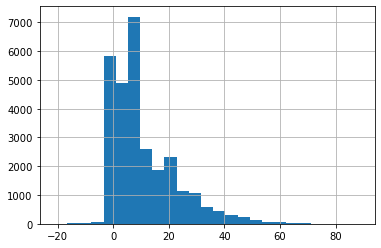

In [10]:
scores.hist(bins=25)